Using device: cpu
Users: 610, Items: 9724, Total Nodes: 10334
Starting Training...
Epoch 005 | Train MSE: 10.9990 | Test RMSE: 3.1757
Epoch 010 | Train MSE: 6.2874 | Test RMSE: 2.2138
Epoch 015 | Train MSE: 1.3873 | Test RMSE: 1.0541
Epoch 020 | Train MSE: 2.4020 | Test RMSE: 1.6579
Epoch 025 | Train MSE: 1.1541 | Test RMSE: 1.0547
Epoch 030 | Train MSE: 1.4322 | Test RMSE: 1.1427
Epoch 035 | Train MSE: 1.1596 | Test RMSE: 1.0369
Epoch 040 | Train MSE: 1.1201 | Test RMSE: 1.1113
Epoch 045 | Train MSE: 1.1073 | Test RMSE: 1.0680
Epoch 050 | Train MSE: 1.0410 | Test RMSE: 1.0156
Epoch 055 | Train MSE: 1.0242 | Test RMSE: 1.0025
Epoch 060 | Train MSE: 0.9625 | Test RMSE: 1.0008
Epoch 065 | Train MSE: 0.9010 | Test RMSE: 0.9709
Epoch 070 | Train MSE: 0.8342 | Test RMSE: 0.9313
Epoch 075 | Train MSE: 0.7730 | Test RMSE: 0.9230
Epoch 080 | Train MSE: 0.7366 | Test RMSE: 0.9151
Epoch 085 | Train MSE: 0.7118 | Test RMSE: 0.9132
Epoch 090 | Train MSE: 0.6985 | Test RMSE: 0.9145
Epoch 095 | Trai

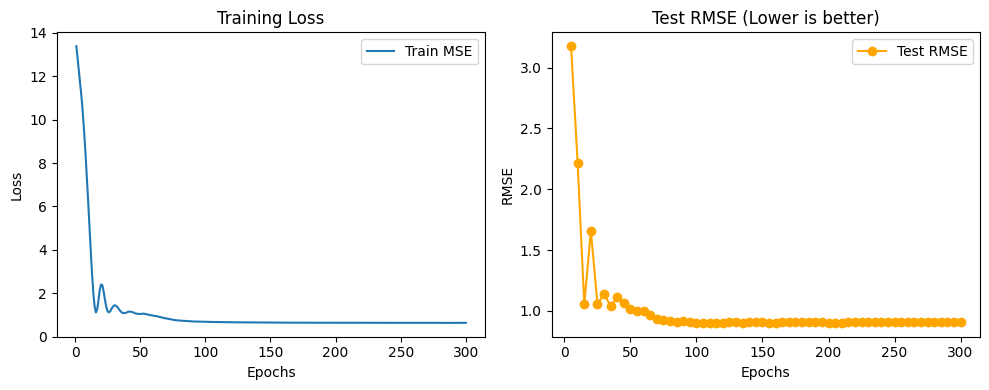


--- Example Prediction ---
User ID (internal): 431
Item ID (internal): 5340
Actual Rating: 4.5
Predicted Rating: 2.81


In [ ]:
import os
import torch
import numpy as np
import pandas as pd
import torch.nn.functional as F
from torch import nn
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch_geometric.nn import SAGEConv
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# ==========================================
# CONFIGURATION & HYPERPARAMETERS
# ==========================================
HP = {
    # System
    'device': torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    'random_seed': 42,
    
    # Data
    'data_path': 'data/ml-latest-small/raw/ml-latest-small/ratings.csv',
    'test_split': 0.2,
    
    # Model Architecture
    'emb_dim': 64,
    'hidden_dim': 128,
    'decoder_dim': 32,
    'n_layers': 2,
    'dropout': 0.1,
    
    # Training
    'epochs': 200,
    'lr': 0.005,
    'weight_decay': 1e-4,
    'eval_freq': 5
}

print(f"Using device: {HP['device']}")
torch.manual_seed(HP['random_seed'])

# ==========================================
# Data Loading & Preprocessing
# ==========================================
if not os.path.exists(HP['data_path']):
    print(f"File not found at {HP['data_path']}. Please adjust path or download dataset.")
    exit()

ratings = pd.read_csv(HP['data_path'])

# Remap UserIDs and MovieIDs to 0-indexed integers
user_ids, users = pd.factorize(ratings['userId'])
item_ids, items = pd.factorize(ratings['movieId'])

ratings['user_id_idx'] = user_ids
ratings['item_id_idx'] = item_ids

num_users = users.size
num_items = items.size
num_nodes = num_users + num_items

print(f"Users: {num_users}, Items: {num_items}, Total Nodes: {num_nodes}")

# Train/Test Split
train_df, test_df = train_test_split(ratings, test_size=HP['test_split'], random_state=HP['random_seed'])

# Construct Graph (Edge Index) from Training Data Only
train_u = torch.tensor(train_df['user_id_idx'].values, dtype=torch.long)
train_i = torch.tensor(train_df['item_id_idx'].values, dtype=torch.long) + num_users

train_edge_index = torch.stack([train_u, train_i], dim=0)

# Make graph undirected
edge_index = torch.cat([train_edge_index, torch.stack([train_i, train_u], dim=0)], dim=1).to(HP['device'])

# Prepare Target Tensors
train_users_input = train_u.to(HP['device'])
train_items_input = train_i.to(HP['device'])
train_ratings = torch.tensor(train_df['rating'].values, dtype=torch.float32).to(HP['device'])

test_users_input = torch.tensor(test_df['user_id_idx'].values, dtype=torch.long).to(HP['device'])
test_items_input = torch.tensor(test_df['item_id_idx'].values + num_users, dtype=torch.long).to(HP['device'])
test_ratings = torch.tensor(test_df['rating'].values, dtype=torch.float32).to(HP['device'])

# ==========================================
# Define GraphSAGE Model
# ==========================================
class GraphSAGE(nn.Module):
    def __init__(self, num_nodes, emb_dim, hidden_dim, n_layers, decoder_dim, dropout):
        super().__init__()
        self.dropout_rate = dropout
        
        # Initial Node Embeddings
        self.emb = nn.Embedding(num_nodes, emb_dim)
        nn.init.xavier_uniform_(self.emb.weight)
        
        # GraphSAGE Layers
        self.convs = nn.ModuleList()
        self.convs.append(SAGEConv(emb_dim, hidden_dim, aggr='mean'))
        
        for _ in range(n_layers - 1):
            self.convs.append(SAGEConv(hidden_dim, hidden_dim, aggr='mean'))
            
        # Regression Decoder (MLP)
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim * 2, decoder_dim),
            nn.ReLU(),
            nn.Dropout(self.dropout_rate),
            nn.Linear(decoder_dim, 1)
        )

    def forward(self, edge_index):
        x = self.emb.weight
        
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            if i < len(self.convs) - 1:
                x = F.relu(x)
                x = F.dropout(x, p=self.dropout_rate, training=self.training)
                x = F.normalize(x, p=2, dim=1) 
            
        return x

    def predict(self, x, user_indices, item_indices):
        u_emb = x[user_indices]
        i_emb = x[item_indices]
        cat_emb = torch.cat([u_emb, i_emb], dim=1)
        return self.decoder(cat_emb).squeeze()

# ==========================================
# Initialize Model & Training
# ==========================================
model = GraphSAGE(
    num_nodes=num_nodes, 
    emb_dim=HP['emb_dim'], 
    hidden_dim=HP['hidden_dim'], 
    n_layers=HP['n_layers'],
    decoder_dim=HP['decoder_dim'],
    dropout=HP['dropout']
).to(HP['device'])

optimizer = torch.optim.Adam(model.parameters(), lr=HP['lr'], weight_decay=HP['weight_decay'])
criterion = nn.MSELoss()

loss_history = []
test_rmse_history = []
eval_epochs = []

print("Starting Training...")
for epoch in range(1, HP['epochs'] + 1):
    model.train()
    
    node_embeddings = model(edge_index)
    preds = model.predict(node_embeddings, train_users_input, train_items_input)
    loss = criterion(preds, train_ratings)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    loss_history.append(loss.item())
    
    # Evaluation
    if epoch % HP['eval_freq'] == 0:
        model.eval()
        with torch.no_grad():
            test_node_embeddings = model(edge_index)
            test_preds = model.predict(test_node_embeddings, test_users_input, test_items_input)
            test_preds = torch.clamp(test_preds, 0.5, 5.0)
            
            mse = mean_squared_error(test_ratings.cpu(), test_preds.cpu())
            rmse = np.sqrt(mse)
            test_rmse_history.append(rmse)
            eval_epochs.append(epoch)
            
        print(f"Epoch {epoch:03d} | Train MSE: {loss.item():.4f} | Test RMSE: {rmse:.4f}")

# ==========================================
# Visualisation & Prediction
# ==========================================
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, HP['epochs'] + 1), loss_history, label='Train MSE')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(eval_epochs, test_rmse_history, label='Test RMSE', color='orange', marker='o')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('Test RMSE (Lower is better)')
plt.legend()

plt.tight_layout()
plt.show()

print("\n--- Example Prediction ---")
model.eval()
with torch.no_grad():
    sample_u = test_users_input[0].item()
    sample_i = test_items_input[0].item()
    sample_true = test_ratings[0].item()
    
    final_embs = model(edge_index)
    pred_rating = model.predict(
        final_embs, 
        torch.tensor([sample_u], device=HP['device']), 
        torch.tensor([sample_i], device=HP['device'])
    ).item()
    
    print(f"User ID (internal): {sample_u}")
    print(f"Item ID (internal): {sample_i}")
    print(f"Actual Rating: {sample_true}")
    print(f"Predicted Rating: {pred_rating:.2f}")

In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score

def evaluate_baselines(train_df, test_df):
    """Calculates RMSE for naive baselines to set a 'floor' for performance."""
    print("\n--- Baseline Evaluation ---")
    test_ratings = test_df['rating'].values
    
    # 1. Global Mean Baseline
    global_mean = train_df['rating'].mean()
    global_preds = np.full_like(test_ratings, global_mean)
    global_rmse = np.sqrt(mean_squared_error(test_ratings, global_preds))
    print(f"Global Mean RMSE: {global_rmse:.4f}")
    
    # 2. Item Mean Baseline
    item_means = train_df.groupby('item_id_idx')['rating'].mean()
    # Map test items to their means; fill missing with global mean
    item_preds = test_df['item_id_idx'].map(item_means).fillna(global_mean).values
    item_rmse = np.sqrt(mean_squared_error(test_ratings, item_preds))
    print(f"Item Mean RMSE:   {item_rmse:.4f}")
    
    return global_rmse, item_rmse

def evaluate_model_comprehensive(model, test_users, test_items, test_ratings, edge_index):
    """Computes multiple metrics for the trained model."""
    model.eval()
    with torch.no_grad():
        # Get embeddings
        embeddings = model(edge_index)
        preds = model.predict(embeddings, test_users, test_items)
        preds = torch.clamp(preds, 0.5, 5.0).cpu().numpy()
        truth = test_ratings.cpu().numpy()
        
        rmse = np.sqrt(mean_squared_error(truth, preds))
        mae = mean_absolute_error(truth, preds)
        r2 = r2_score(truth, preds)
        
        print("\n--- GraphSAGE Model Evaluation ---")
        print(f"Model RMSE: {rmse:.4f}")
        print(f"Model MAE:  {mae:.4f}")
        print(f"Model R^2:  {r2:.4f}")
        
        return rmse, mae, r2

base_global, base_item = evaluate_baselines(train_df, test_df)
evaluate_model_comprehensive(model, test_users_input, test_items_input, test_ratings, edge_index)

if test_rmse_history[-1] < base_item:
    print("\nSUCCESS: Model beats the Item Mean baseline.")
else:
    print("\nWARNING: Model fails to beat simple baselines. Check hyperparameters or data sparsity.")


--- Baseline Evaluation ---
Global Mean RMSE: 1.0488
Item Mean RMSE:   0.9827

--- GraphSAGE Model Evaluation ---
Model RMSE: 0.9052
Model MAE:  0.6811
Model R^2:  0.2551

SUCCESS: Model beats the Item Mean baseline.
